In [108]:
import pandas as pd
import yfinance as yf
import datetime
import requests
import json
pd.set_option('display.max_rows', 500)

In [53]:
class Stock():
    def retrieve(self, interval, pk):
        """
        interval is in ['5D', '60D', 'YTD', '1Y', '2Y']
        """
        try:
            ticker, name, time_format, hist = self._get_hist(pk, interval)
        except ValueError:
            return {"data": []}
        else:
            self._simple_moving_average(hist, 50)
            self._simple_moving_average(hist, 200)

            hist["Volume"] = hist.apply(
                lambda x: [x["Volume"], 1]
                if x["Open"] > x["Close"]
                else [x["Volume"], -1],
                axis=1,
            )

            data = hist[["Open", "Close", "Low", "High"]].round(2).copy()
            json_format_data = data.to_json(orient="split", date_format="epoch")
            result = json.loads(json_format_data)
            result["name"] = name + " (" + ticker + ")"
            result["index"] = [
                datetime.datetime.fromtimestamp(x / 1000.0).strftime(time_format)
                for x in result["index"]
            ]
            result["50DSMA"] = pd.Series(hist["50D-SMA"]).fillna("").tolist()
            result["200DSMA"] = pd.Series(hist["200D-SMA"]).fillna("").tolist()
            result["volume"] = [
                [idx, item[0], item[1]]
                for idx, item in enumerate(pd.Series(hist["Volume"]).tolist())
            ]

            return result

    def close(self, interval, pk):
        try:
            ticker, name, _ , hist = self._get_hist(pk, interval)
        except ValueError:
            return {"data": []}
        else:
            result = {}
            result["name"] = name + " (" + ticker + ")"
            result["ticker"] = ticker
            result["data"] = pd.Series(hist["Close"]).round(2).tolist()

            return result

    def _simple_moving_average(self, data, time_period):
        data[str(time_period) + "D-SMA"] = (
            data["Close"].rolling(window=time_period).mean().round(2)
        )

    def _get_info(self, id):
        yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
        user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
        params = {"q": id, "quotes_count": 1, "country": "United States"}

        res = requests.get(
            url=yfinance, params=params, headers={"User-Agent": user_agent}
        )
        data = res.json()

        company_code = data["quotes"][0]["symbol"]
        company_name = data["quotes"][0]["shortname"]
        return (company_code, company_name)

    def _get_hist(self, id, interval):
        try:
            ticker, name = self._get_info(id)
        except (KeyError, IndexError):
            raise ValueError
        else:
            time_format = "%Y-%m-%d"
            time_interval = "1d"
            if interval == "5D":
                time_format = "%Y-%m-%d %H:%M"
                time_interval = "5m"
            elif interval == "60D":
                time_format = "%Y-%m-%d %H:%M"
                time_interval = "60m"

            stock = yf.Ticker(ticker)
            hist = stock.history(period=interval, interval=time_interval)

            if hist.empty:
                raise ValueError
            
            return (ticker, name, time_format, hist)

In [113]:
ticker = yf.Ticker("APPL")
ticker.info

{'exchange': 'YHD',
 'quoteType': 'MUTUALFUND',
 'symbol': 'APPL',
 'underlyingSymbol': 'APPL',
 'timeZoneFullName': 'America/New_York',
 'timeZoneShortName': 'EDT',
 'uuid': 'fc74d387-06b2-3b3b-9d2b-a67dd39f76c4',
 'gmtOffSetMilliseconds': -14400000,
 'maxAge': 86400,
 'trailingPegRatio': None}

In [114]:
yfinance = "https://query2.finance.yahoo.com/v1/finance/search"
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/108.0.0.0 Safari/537.36"
params = {"q": "APPL", "quotes_count": 1, "country": "United States"}

res = requests.get(
    url=yfinance, params=params, headers={"User-Agent": user_agent}
)
data = res.json()
data

{'explains': [],
 'count': 17,
 'quotes': [{'exchange': 'NMS',
   'shortname': 'Apple Inc.',
   'quoteType': 'EQUITY',
   'symbol': 'AAPL',
   'index': 'quotes',
   'score': 908519.0,
   'typeDisp': 'Equity',
   'longname': 'Apple Inc.',
   'exchDisp': 'NASDAQ',
   'sector': 'Technology',
   'sectorDisp': 'Technology',
   'industry': 'Consumer Electronics',
   'industryDisp': 'Consumer Electronics',
   'dispSecIndFlag': True,
   'isYahooFinance': True},
  {'exchange': 'NGM',
   'shortname': 'Applied Optoelectronics, Inc.',
   'quoteType': 'EQUITY',
   'symbol': 'AAOI',
   'index': 'quotes',
   'score': 51963.0,
   'typeDisp': 'Equity',
   'longname': 'Applied Optoelectronics, Inc.',
   'exchDisp': 'NASDAQ',
   'sector': 'Technology',
   'sectorDisp': 'Technology',
   'industry': 'Communication Equipment',
   'industryDisp': 'Communication Equipment',
   'isYahooFinance': True},
  {'exchange': 'NMS',
   'shortname': 'Applied Materials, Inc.',
   'quoteType': 'EQUITY',
   'symbol': 'AMAT

In [115]:
ticker = data["quotes"][0]["symbol"]
name = data["quotes"][0]["shortname"]
stock = yf.Ticker(ticker)
stock.history(period="5D")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-07-31 00:00:00-04:00,196.059998,196.490005,195.259995,196.449997,38824100,0.0,0.0
2023-08-01 00:00:00-04:00,196.240005,196.729996,195.279999,195.610001,35175100,0.0,0.0
2023-08-02 00:00:00-04:00,195.039993,195.179993,191.850006,192.580002,50389300,0.0,0.0
2023-08-03 00:00:00-04:00,191.570007,192.369995,190.690002,191.169998,61235200,0.0,0.0
2023-08-04 00:00:00-04:00,185.520004,187.380005,181.919998,181.990005,115799700,0.0,0.0


In [116]:
stock.history(period="5D", interval="5h")

AAPL: Invalid input - interval=5h is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [117]:
hist = stock.history(period="5D", interval="1d")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-07-31 00:00:00-04:00,196.059998,196.490005,195.259995,196.449997,38824100,0.0,0.0
2023-08-01 00:00:00-04:00,196.240005,196.729996,195.279999,195.610001,35175100,0.0,0.0
2023-08-02 00:00:00-04:00,195.039993,195.179993,191.850006,192.580002,50389300,0.0,0.0
2023-08-03 00:00:00-04:00,191.570007,192.369995,190.690002,191.169998,61235200,0.0,0.0
2023-08-04 00:00:00-04:00,185.520004,187.380005,181.919998,181.990005,115799700,0.0,0.0


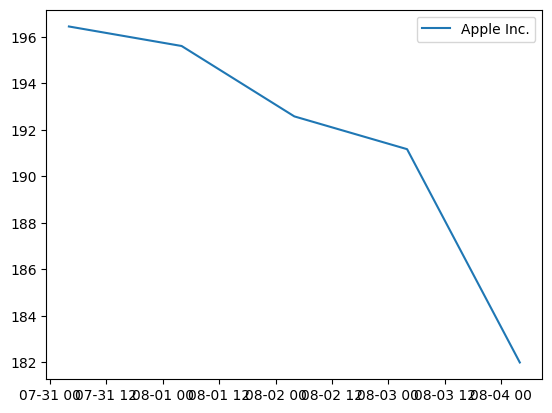

In [118]:
import matplotlib.pyplot as plt
plt.plot(hist.index.values, hist["Close"], label=name)
plt.legend(loc="upper right")

In [119]:
data = hist[["Open", "Close", "Low", "High"]].round(2).copy()
data

,Open,Close,Low,High
Date,,,,
2023-07-31 00:00:00-04:00,196.06,196.45,195.26,196.49
2023-08-01 00:00:00-04:00,196.24,195.61,195.28,196.73
2023-08-02 00:00:00-04:00,195.04,192.58,191.85,195.18
2023-08-03 00:00:00-04:00,191.57,191.17,190.69,192.37
2023-08-04 00:00:00-04:00,185.52,181.99,181.92,187.38


In [126]:
[type(x) for x in data.index.values]

[numpy.datetime64,
 numpy.datetime64,
 numpy.datetime64,
 numpy.datetime64,
 numpy.datetime64]

In [127]:
json_format_data = data.to_json(orient="split", date_format="epoch")
result = json.loads(json_format_data)
result

{'columns': ['Open', 'Close', 'Low', 'High'],
 'index': [1690776000000,
  1690862400000,
  1690948800000,
  1691035200000,
  1691121600000],
 'data': [[196.06, 196.45, 195.26, 196.49],
  [196.24, 195.61, 195.28, 196.73],
  [195.04, 192.58, 191.85, 195.18],
  [191.57, 191.17, 190.69, 192.37],
  [185.52, 181.99, 181.92, 187.38]]}

In [128]:
data['index'] = [datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d")for x in result["index"]]
data

,Open,Close,Low,High,index
Date,,,,,
2023-07-31 00:00:00-04:00,196.06,196.45,195.26,196.49,2023-07-31
2023-08-01 00:00:00-04:00,196.24,195.61,195.28,196.73,2023-08-01
2023-08-02 00:00:00-04:00,195.04,192.58,191.85,195.18,2023-08-02
2023-08-03 00:00:00-04:00,191.57,191.17,190.69,192.37,2023-08-03
2023-08-04 00:00:00-04:00,185.52,181.99,181.92,187.38,2023-08-04


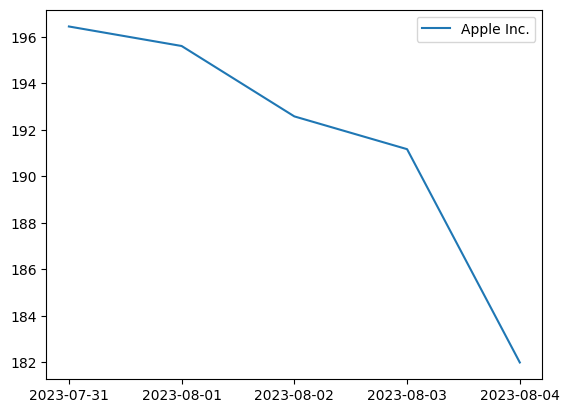

In [129]:
plt.plot(data["index"], data["Close"], label=name)
plt.legend(loc="upper right")

In [130]:
# Moving average
def moving_average(data, time_period):
    data[str(time_period) + "D-SMA"] = (
        data["Close"].rolling(window=time_period).mean().round(2)
    )

In [159]:
moving_average(data, 3)
data

,Open,Close,Low,High,index,3D-SMA
Date,,,,,,
2023-07-31 00:00:00-04:00,196.06,196.45,195.26,196.49,2023-07-31,NaN
2023-08-01 00:00:00-04:00,196.24,195.61,195.28,196.73,2023-08-01,NaN
2023-08-02 00:00:00-04:00,195.04,192.58,191.85,195.18,2023-08-02,194.88
2023-08-03 00:00:00-04:00,191.57,191.17,190.69,192.37,2023-08-03,193.12
2023-08-04 00:00:00-04:00,185.52,181.99,181.92,187.38,2023-08-04,188.58


In [160]:
# values = {"3D-SMA": 0.0}
# data = data.fillna(value=values)
# data

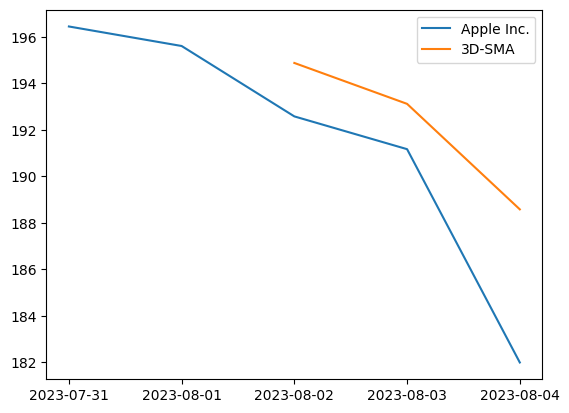

In [161]:
plt.plot(data["index"], data["Close"],label=name)
plt.plot(data["index"], data["3D-SMA"], label="3D-SMA")
plt.legend(loc="upper right")

In [99]:
# S&P 500 Tickers
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [100]:
data = yf.download(tickers.Symbol.to_list(),'2022-8-8','2023-8-5', auto_adjust=True)['Close']
data

[*********************100%***********************]  503 of 503 completed


2 Failed downloads:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2022-8-8 -> 2023-8-5)')


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-08 00:00:00,131.627853,15.020000,187.541763,164.119019,134.868515,138.925720,106.949158,44.150002,305.385559,434.339996,...,65.740631,71.742546,85.977158,36.420670,98.433838,116.303276,112.292343,330.320007,51.953251,172.483398
2022-08-09 00:00:00,128.012344,14.620000,185.109314,164.168793,134.782043,142.976334,105.879669,44.650002,304.854187,426.570007,...,65.880310,72.635681,87.562347,35.751137,96.843643,114.762390,111.627480,320.149994,52.471920,168.062546
2022-08-10 00:00:00,131.687424,15.070000,187.927902,168.469116,135.445129,143.825974,108.195251,45.230000,311.437653,438.399994,...,65.201851,72.917213,88.393608,36.469902,99.243744,116.970665,114.088463,328.869995,54.162395,172.532974
2022-08-11 00:00:00,131.061676,14.990000,190.563065,167.722534,136.540695,146.434174,108.411118,45.980000,309.410400,434.890015,...,67.416824,72.431816,90.950653,36.597900,99.895622,115.527916,114.118233,336.000000,54.988419,171.660690
2022-08-12 00:00:00,132.650909,15.250000,195.495575,171.316086,137.040421,149.149567,109.382492,47.040001,315.334473,445.670013,...,68.584167,73.742393,91.741180,37.070511,102.108055,115.969582,116.321213,346.739990,55.920101,174.128845
2022-08-15 00:00:00,132.998535,15.330000,198.198318,172.401123,136.742508,149.466705,109.794594,46.990002,315.226227,451.019989,...,68.175102,74.451096,90.101555,37.021278,102.226593,116.048088,115.834969,349.410004,56.323505,172.919556
2022-08-16 00:00:00,131.876160,15.500000,202.320023,172.241867,136.992371,151.290207,109.922142,47.509998,315.669067,447.559998,...,67.686211,74.761742,89.262222,36.213902,102.680931,116.833267,115.229652,344.910004,56.659687,170.282867
2022-08-17 00:00:00,141.332047,14.960000,202.686813,173.754929,135.925644,148.188278,108.470001,47.520000,313.376221,437.820007,...,65.271698,74.684082,89.984428,35.199749,101.061111,116.901970,113.760994,340.450012,56.746731,170.947006
2022-08-18 00:00:00,139.027695,14.840000,200.283325,173.356735,135.781509,148.564880,107.891090,47.830002,314.370117,439.029999,...,65.361496,74.742332,92.112045,35.800369,101.090736,115.763474,113.641907,342.380005,56.862801,168.677094


In [101]:
df = data
df['Date'] = [x.strftime('%Y-%m-%d') for x in df.index.values]
df

C:\Users\Ericz\AppData\Local\Temp\ipykernel_14584\1940546447.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Date'] = [x.strftime('%Y-%m-%d') for x in df.index.values]


,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,Date
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-08 00:00:00,131.627853,15.020000,187.541763,164.119019,134.868515,138.925720,106.949158,44.150002,305.385559,434.339996,...,71.742546,85.977158,36.420670,98.433838,116.303276,112.292343,330.320007,51.953251,172.483398,2022-08-08
2022-08-09 00:00:00,128.012344,14.620000,185.109314,164.168793,134.782043,142.976334,105.879669,44.650002,304.854187,426.570007,...,72.635681,87.562347,35.751137,96.843643,114.762390,111.627480,320.149994,52.471920,168.062546,2022-08-09
2022-08-10 00:00:00,131.687424,15.070000,187.927902,168.469116,135.445129,143.825974,108.195251,45.230000,311.437653,438.399994,...,72.917213,88.393608,36.469902,99.243744,116.970665,114.088463,328.869995,54.162395,172.532974,2022-08-10
2022-08-11 00:00:00,131.061676,14.990000,190.563065,167.722534,136.540695,146.434174,108.411118,45.980000,309.410400,434.890015,...,72.431816,90.950653,36.597900,99.895622,115.527916,114.118233,336.000000,54.988419,171.660690,2022-08-11
2022-08-12 00:00:00,132.650909,15.250000,195.495575,171.316086,137.040421,149.149567,109.382492,47.040001,315.334473,445.670013,...,73.742393,91.741180,37.070511,102.108055,115.969582,116.321213,346.739990,55.920101,174.128845,2022-08-12
2022-08-15 00:00:00,132.998535,15.330000,198.198318,172.401123,136.742508,149.466705,109.794594,46.990002,315.226227,451.019989,...,74.451096,90.101555,37.021278,102.226593,116.048088,115.834969,349.410004,56.323505,172.919556,2022-08-15
2022-08-16 00:00:00,131.876160,15.500000,202.320023,172.241867,136.992371,151.290207,109.922142,47.509998,315.669067,447.559998,...,74.761742,89.262222,36.213902,102.680931,116.833267,115.229652,344.910004,56.659687,170.282867,2022-08-16
2022-08-17 00:00:00,141.332047,14.960000,202.686813,173.754929,135.925644,148.188278,108.470001,47.520000,313.376221,437.820007,...,74.684082,89.984428,35.199749,101.061111,116.901970,113.760994,340.450012,56.746731,170.947006,2022-08-17
2022-08-18 00:00:00,139.027695,14.840000,200.283325,173.356735,135.781509,148.564880,107.891090,47.830002,314.370117,439.029999,...,74.742332,92.112045,35.800369,101.090736,115.763474,113.641907,342.380005,56.862801,168.677094,2022-08-18


In [102]:
df.set_index('Date', inplace=True, drop=True)
df.to_csv("s&p500.csv")

In [103]:
df = pd.read_csv("s&p500.csv")
df

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2022-08-08,131.627853,15.020000,187.541763,164.119019,134.868515,138.925720,106.949158,44.150002,305.385559,...,65.740631,71.742546,85.977158,36.420670,98.433838,116.303276,112.292343,330.320007,51.953251,172.483398
1,2022-08-09,128.012344,14.620000,185.109314,164.168793,134.782043,142.976334,105.879669,44.650002,304.854187,...,65.880310,72.635681,87.562347,35.751137,96.843643,114.762390,111.627480,320.149994,52.471920,168.062546
2,2022-08-10,131.687424,15.070000,187.927902,168.469116,135.445129,143.825974,108.195251,45.230000,311.437653,...,65.201851,72.917213,88.393608,36.469902,99.243744,116.970665,114.088463,328.869995,54.162395,172.532974
3,2022-08-11,131.061676,14.990000,190.563065,167.722534,136.540695,146.434174,108.411118,45.980000,309.410400,...,67.416824,72.431816,90.950653,36.597900,99.895622,115.527916,114.118233,336.000000,54.988419,171.660690
4,2022-08-12,132.650909,15.250000,195.495575,171.316086,137.040421,149.149567,109.382492,47.040001,315.334473,...,68.584167,73.742393,91.741180,37.070511,102.108055,115.969582,116.321213,346.739990,55.920101,174.128845
5,2022-08-15,132.998535,15.330000,198.198318,172.401123,136.742508,149.466705,109.794594,46.990002,315.226227,...,68.175102,74.451096,90.101555,37.021278,102.226593,116.048088,115.834969,349.410004,56.323505,172.919556
6,2022-08-16,131.876160,15.500000,202.320023,172.241867,136.992371,151.290207,109.922142,47.509998,315.669067,...,67.686211,74.761742,89.262222,36.213902,102.680931,116.833267,115.229652,344.910004,56.659687,170.282867
7,2022-08-17,141.332047,14.960000,202.686813,173.754929,135.925644,148.188278,108.470001,47.520000,313.376221,...,65.271698,74.684082,89.984428,35.199749,101.061111,116.901970,113.760994,340.450012,56.746731,170.947006
8,2022-08-18,139.027695,14.840000,200.283325,173.356735,135.781509,148.564880,107.891090,47.830002,314.370117,...,65.361496,74.742332,92.112045,35.800369,101.090736,115.763474,113.641907,342.380005,56.862801,168.677094
9,2022-08-19,136.693497,14.170000,199.829620,170.738724,136.319672,150.665848,107.989212,47.279999,310.266571,...,63.525661,74.693787,91.819260,35.229294,98.305435,114.487572,112.361801,328.410004,55.731152,168.032806


In [112]:
BFB = pd.read_csv("BFB.csv")
BFB = BFB[['Date', 'Close/Last']].rename(columns={'Close/Last': 'BF.B'})
BFB['Date'] = pd.to_datetime(BFB['Date'])
BFB = BFB.sort_values('Date')
BFB['BF.B'] = BFB['BF.B'].replace('[\$,]', '', regex=True).astype(float)
BFB

,Date,BF.B
249,2022-08-08,74.26
248,2022-08-09,75.43
247,2022-08-10,75.93
246,2022-08-11,75.40
245,2022-08-12,76.14
244,2022-08-15,76.95
243,2022-08-16,77.45
242,2022-08-17,77.66
241,2022-08-18,77.66
240,2022-08-19,77.24


In [113]:
BRKB = pd.read_csv("BRKB.csv")
BRKB = BRKB[['Date', 'Close/Last']].rename(columns={'Close/Last': 'BRK.B'})
BRKB['Date'] = pd.to_datetime(BRKB['Date'])
BRKB = BRKB.sort_values('Date')
BRKB['BRK.B'] = BRKB['BRK.B'].replace('[\$,]', '', regex=True).astype(float)
BRKB

,Date,BRK.B
249,2022-08-08,292.34
248,2022-08-09,292.77
247,2022-08-10,295.11
246,2022-08-11,296.47
245,2022-08-12,301.55
244,2022-08-15,302.82
243,2022-08-16,306.65
242,2022-08-17,304.26
241,2022-08-18,304.27
240,2022-08-19,297.28


In [115]:
df['BF.B'] = BFB['BF.B']
df['BRK.B'] = BRKB['BRK.B']
df.to_csv("s&p500.csv")